# Salamander Counts in Eliza Spring

![An aerial photograph of the green pool and amphitheater at the Eliza Spring stream. Courtesy of the City of Austin.](eliza-springs.jpg)

This project I tried to find a new source for my datasets. First, I looked at the World Bank data. A lot of it was interesting, but all the data showed a relationship with time, while I wanted to do something else. Then, I moved to looking at the [City of Austin Open Data Portal](https://data.austintexas.gov/). All of the data is publicly accessible and published by the City of Austin.

A dataset that I found intriguing was [Barton Spring Salamander Counts and Covariates](https://data.austintexas.gov/Environment/Barton-Spring-Salamander-Counts-and-Covariates/brj7-e355/about_data). The data focuses on two locations at the Edwards Aquifer: Parthenia Spring and Eliza Spring. I chose to focus on Eliza Spring, since there tend to be more 0 salamander counts at Parthenia Spring. Data provided includes Salamander counts and other possibly correlated data relating to the spring, where each record represents a unique observation.

My question in this lab was understanding how the population size and distribution of Salamanders in Eliza Spring varies based on sediment coverage.

## Setup

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
from scipy.interpolate import PchipInterpolator

In [2]:
df = pd.read_csv("salamanders.csv")

First, we need to clean up the data. The main thing is removing NaN (not a number) rows so that they don't end up being counted as 0-values in the resulting data. I created a combined column for Eliza salamander counts, since the distinction between Juvenile, Adult, and Subadult is less important, especially because juveniles tend to lack data.

The other important thing that I did was reindexing the dataframe, since the graphing of the posterior done below relies on indices.

In [3]:
# Filter out any rows where Eliza Adult, Subadult, and Juvenile counts are N/A.
df = df[df["Eliza_juvenile"].notna()
      | df["Eliza_subadult"].notna()
      | df["Eliza_adult"].notna()]
# Filter out any rows were Eliza_sedcov is N/A.
df = df[df["Eliza_sedcov"].notna()]

# Add together Eliza Adult, Subadult, and Juvenile counts into "Eliza" column.
column_names = ["Eliza_juvenile", "Eliza_subadult", "Eliza_adult"]
df["Eliza"] = df[column_names].sum(axis=1)

# Reindex rows. Normally, when rows are deleted, the indices aren't shifted.
# Instead, the index of the deleted row just doesn't exist. This is an issue
# because the graphing code below relies on indices, so we reindex the
# data starting from 0.
df = df.reset_index(drop=True)

In [4]:
# Print the dataframe, excluding Parthenia since we're focusing on
# Eliza instead.
df.drop(["ID", "Year-Month", "Parthenia_juvenile", "Parthenia_subadult",
         "Parthenia_adult", "Parthenia_sedcov", "Parthenia_filalgae"], axis=1)

,Eliza_juvenile,Eliza_subadult,Eliza_adult,Discharge_BS,Eliza_sedcov,Eliza_filalgae,Eliza
0,91.0,124.0,16.0,40.5,52.50,0.25,231.0
1,90.0,167.0,40.0,42.0,43.75,0.00,297.0
2,124.0,247.0,34.0,46.1,52.50,1.25,405.0
3,166.0,332.0,96.0,62.9,26.25,1.00,594.0
4,51.0,167.0,124.0,85.5,35.00,2.75,342.0
...,...,...,...,...,...,...,...
94,20.0,159.0,28.0,20.2,8.75,60.00,207.0
95,10.0,89.0,40.0,30.3,11.25,77.50,139.0
96,1.0,34.0,40.0,78.5,70.00,0.00,75.0
97,0.0,45.0,38.0,60.9,89.50,25.00,83.0


Here we can see the new Eliza row, formed by combining the Juvenile, Subadult, and Adult values. Also, there are three relationships that could be analyzed: salamander counts at Eliza Spring versus mean monthly discharge, filamentous algae, or sediment coverage.

Let's look at the salamander counts distribution:

<Axes: >

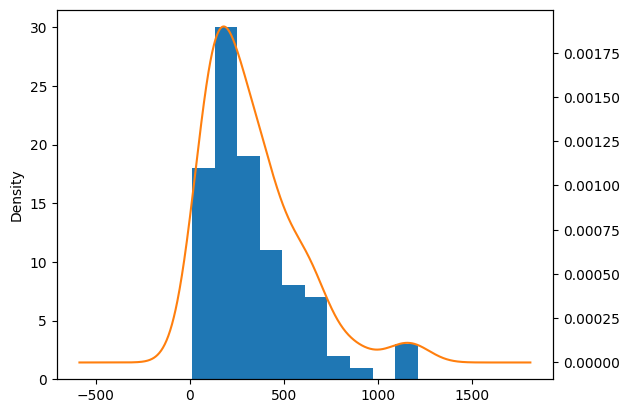

In [5]:
# Plot the histogram and KDE in one graph.
ax = df["Eliza"].plot.hist()
df["Eliza"].plot.kde(ax=ax, secondary_y=True)

We can see that it is a pretty unremarkable distribution that's slightly skewed left. All values are positive (since the values represent counts), and most data is in the range 0–1000.

### Monthly discharge

One variable I could analyze is Mean Monthly Discharge.

<Axes: xlabel='Discharge_BS', ylabel='Eliza'>

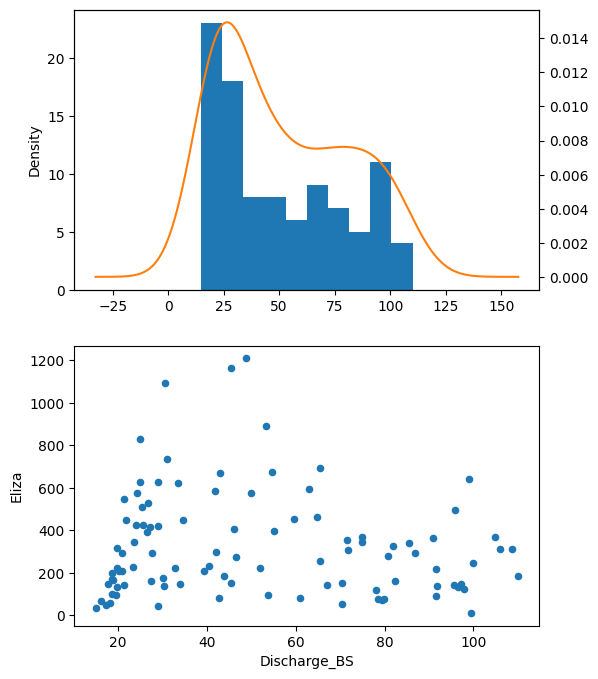

In [6]:
fig, ax = plt.subplots(2)
fig.set_size_inches(6, 8)

# Plot the histogram and KDE.
df["Discharge_BS"].plot.hist(ax=ax[0])
df["Discharge_BS"].plot.kde(ax=ax[0], secondary_y=True)

# Plot a discharge vs salamander count graph.
df.plot(kind="scatter", ax=ax[1], x="Discharge_BS", y="Eliza")

Two things prevented me from using this variable:

1. Discharge follows a strange distribution. It's almost multimodal.
2. The relationship between discharge and salamander counts doesn't follow a linear relationship, nor does it look easy to model with the tools we learned to modify linear relationships.

### Sediment coverage

Another variable I could analyze is Sediment Coverage.

<Axes: xlabel='Eliza_sedcov', ylabel='Eliza'>

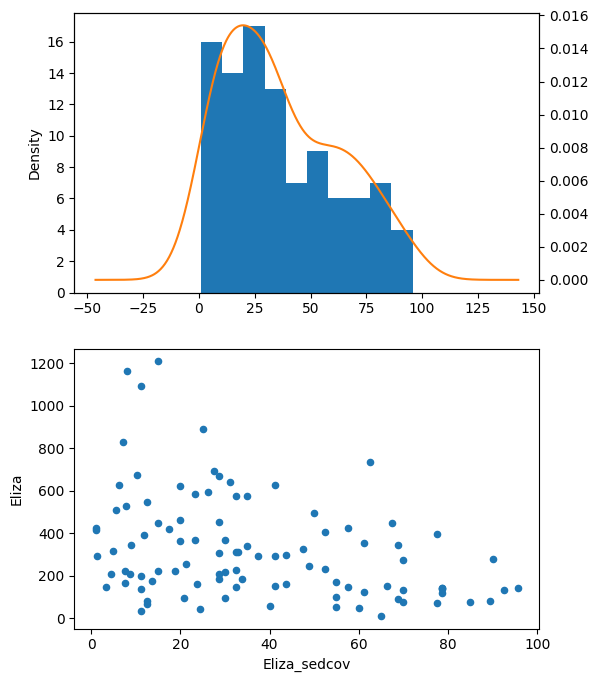

In [7]:
fig, ax = plt.subplots(2)
fig.set_size_inches(6, 8)

# Plot the histogram and KDE.
df["Eliza_sedcov"].plot.hist(ax=ax[0])
df["Eliza_sedcov"].plot.kde(ax=ax[0], secondary_y=True)

# Plot a sedcov vs salamander count graph.
df.plot(kind="scatter", ax=ax[1], x="Eliza_sedcov", y="Eliza")

The distribution is a little less strange than the previous one. Better yet, there is a distinct negative sloping relationship between sediment coverage and salamander counts. There tends to be a variance between salamander counts at low sediment counts compared to high ones.

### Filamentous algae

The last thing I could try is analyzing filamentous algae.

<Axes: xlabel='Eliza_filalgae', ylabel='Eliza'>

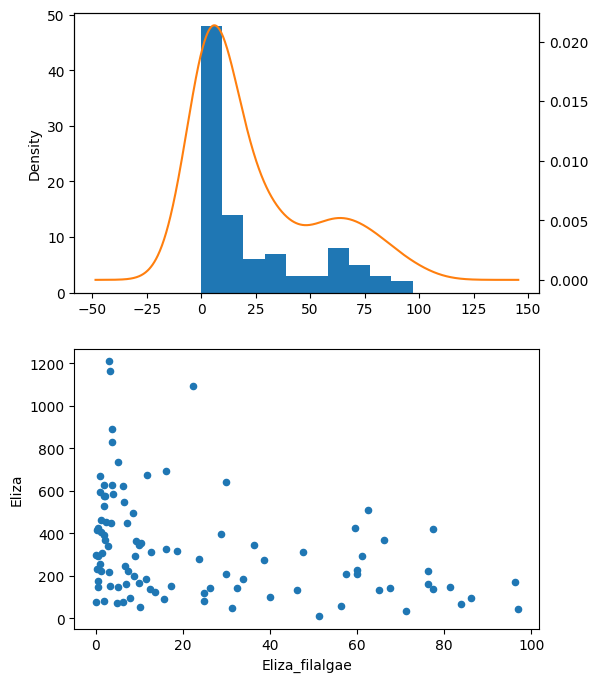

In [8]:
fig, ax = plt.subplots(2)
fig.set_size_inches(6, 8)

# Plot the histogram and KDE.
df["Eliza_filalgae"].plot.hist(ax=ax[0])
df["Eliza_filalgae"].plot.kde(ax=ax[0], secondary_y=True)

# Plot a sedcov vs fil. algae count graph.
df.plot(kind="scatter", ax=ax[1], x="Eliza_filalgae", y="Eliza")

The trend is similar to that of sediment coverage, the clustering of filalgae values from 0 to 20 is more dense, while for sediment coverage, it's more evently distributed.

These analyses led me to determine that sediment coverage would be the best to analyze using a linear model.

## Models

Having chosen the sediment coverage vs. salamander count relationship, I moved on to create a linear model for the data.

### Normal

My first thought was modeling the decreasing variance of the salamander count as sediment coverage increases. We played around with variance with the baby dataset, so I thought I would have a go with that model.

For the likelihood, I chose a normal distribution. I chose it because it tends to be a good starting point for modeling. As in previous projects, I know little about the data, so I wanted as few assumptions as possible.

Then, I created two linear models: one of the mean and one for the standard deviation. As I said earlier, my idea was that the change in standard deviation is significant and requires a separate linear model.

For the priors, I chose two normal distributions. I wanted weak priors due to my low confidence about trends in the data, so I started out with normal and half-normal distributions with default sigma values of 10.

In [9]:
with pm.Model() as model1:
    # Priors for μ, the mean line
    α = pm.Normal("α", sigma=10)
    β = pm.Normal("β", sigma=10)

    # Priors for σ, the standard deviation line
    γ = pm.HalfNormal("γ", sigma=10)
    δ = pm.HalfNormal("δ", sigma=10)

    # Mean line
    μ = pm.Deterministic("μ", α + β * pm.math.sqrt(df["Eliza_sedcov"]))

    # Standard deviation line
    σ = pm.Deterministic("σ", γ + δ * df["Eliza_sedcov"])

    # Normal likelihood
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=df["Eliza"])

    idata1 = pm.sample()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, γ, δ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


In [10]:
pm.sample_posterior_predictive(idata1, model=model1, extend_inferencedata=True)

Sampling: [y_pred]


Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

<Axes: xlabel='y_pred'>

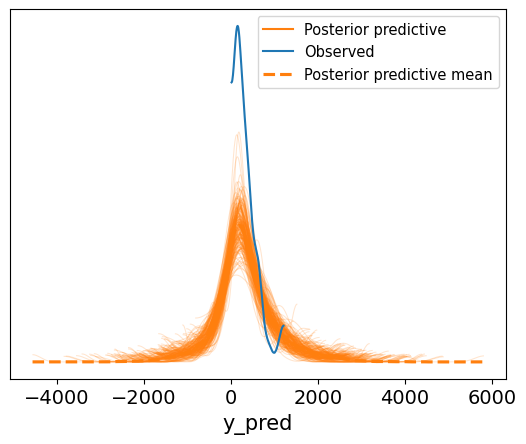

In [11]:
az.plot_ppc(idata1, num_pp_samples=200, colors=["C1", "C0", "C1"])

The posterior predictive strongly suggests that the data is a poor fit for this model. The distribution of the data itself is a downward sloping curve, starting at some maximum value. Notably, the data supports nonnegative numbers. The posterior predictive, on the other hand, spans positive and negative numbers, and gets nowhere near the maximum value for the data.

At this point, I was pretty confident that the model was poor for this task because the assumptions for the model and data don't match up. The fact that I wanted a weak prior is not reflected in this PPC. Before trying a different model, I first tried to modify the function used to modify the mean line. I also modified sigma values. None of these experiments produced significantly different results.

### Negative binomial

With Mr. Arredondo's advice, I moved on to try a negative binomial likelihood. This is a discrete distribution, which fits well due to its support of only positive numbers and shape.

My priors for this distribution are once again normal and weak for the same reasons as I described earlier.

In [12]:
with pm.Model() as model2:
    # Priors for the linear part of the model
    α = pm.Normal("α", mu=0, sigma=1)
    β = pm.Normal("β", mu=0, sigma=10)

    # The linear part of the model. Exponentiated to make all values positive.
    μ = pm.Deterministic("μ", pm.math.exp(α + β * df["Eliza_sedcov"]))

    # Prior for standard deviation.
    σ = pm.HalfNormal("σ", 10)

    # Negative binomail likelihood.
    y_pred = pm.NegativeBinomial("y_pred", mu=μ, alpha=σ, observed=df["Eliza"])

    idata2 = pm.sample()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


In [13]:
pm.sample_posterior_predictive(idata2, model=model2, extend_inferencedata=True)

Sampling: [y_pred]


Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

<Axes: xlabel='y_pred'>

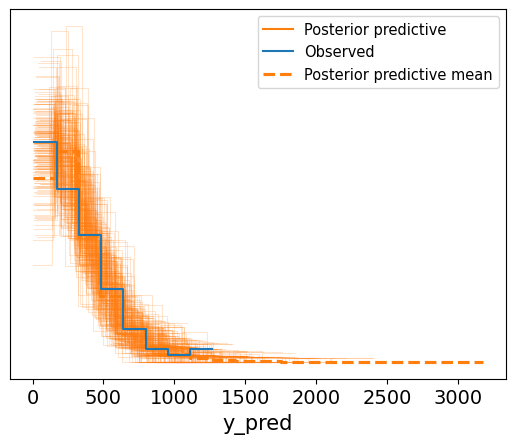

In [14]:
az.plot_ppc(idata2, num_pp_samples=200, colors=["C1", "C0", "C1"])

In this case, the PPC shows that the model performs remarkably well to represent the data distribution. We can also plot the model's predictions onto our original data:

Text(0, 0.5, 'Number of salamanders')

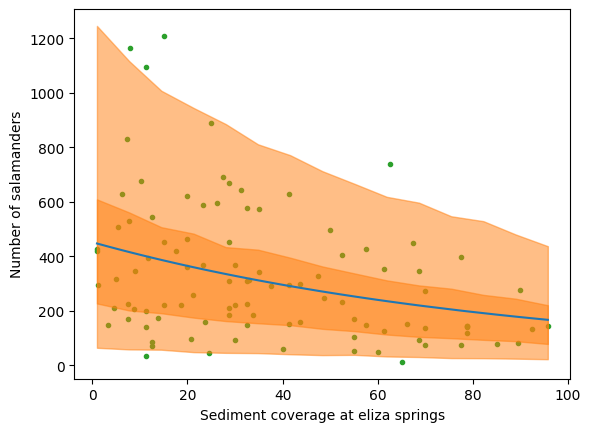

In [15]:
# Data for the mean line
mean_line = idata2.posterior["μ"].mean(("chain", "draw"))

# Data for the model plot
sedcovs = np.random.normal(df["Eliza_sedcov"].values, 0.01)
idx = np.argsort(sedcovs)
x = np.linspace(sedcovs.min(), sedcovs.max(), 15)
y_pred_q = idata2.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
y_hat_bounds = iter(
    [
        PchipInterpolator(sedcovs[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)

# Create a plot for all elements
_, ax = plt.subplots()

# Plot the original data
ax.plot(df["Eliza_sedcov"], df["Eliza"], "C2.", zorder=-3)

# Plot the mean line
ax.plot(df["Eliza_sedcov"][idx], mean_line[idx], c="C0")

# Plot the model
for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C1", alpha=0.5)

# Labels
ax.set_xlabel("Sediment coverage at eliza springs")
ax.set_ylabel("Number of salamanders")

I believe that this model is much better for analyzing salamander counts.

The model fits the data well, which was important for my analysis because I wanted weak priors. Furthermore, the model captures the downward slope of the data and the decreasing variance at greater sediment coverage.

## Conclusion

This time, I managed to find a good working model for the data. The model answers my question posed at the beginning of the lab because it can now be used to make predictions on the sediment coverage/salamander count trend. The data is well-suited for a linear model because there seems to be a relationship between two variables: sediment coverage and salamander count. While the first model did not work, the second model was a good representation of the underlying trend.

In general, higher sediment coverage corresponds to lower numbers of salamanders. Also, the higher the sediment coverage, the more variance there is in salamander count. This could be explained by higher sediment coverage being a sign of environmental degradation. The variance could be explained by other factors affecting salamander counts (high sediment coverage might severely decrease salamander counts, but when there isn't high sediment coverage, other factors could be contributing to the number). For these reasons, the model and data seem to be intuitively linked to reality.

## Sources

- [Barton Spring Salamander Counts and Covariates](https://data.austintexas.gov/Environment/Barton-Spring-Salamander-Counts-and-Covariates/brj7-e355/about_data), City of Austin Open Data Portal
- [NegativeBinomial Distribution (PreliZ)](https://preliz.readthedocs.io/en/latest/examples/gallery/negativebinomial.html)
- [Negative binomial distribution (Wikipedia)](https://en.wikipedia.org/wiki/Negative_binomial_distribution)
- [Can a finite decimal number be a discrete variable?](https://stats.stackexchange.com/questions/648227/)
- [Effects of Sedimentation on the Diversity of Salamanders in a Southern Appalachian Headwater Stream](https://highlandsbiological.org/wp-content/uploads/2019/03/brannonpurvis2008.pdf)